In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Unconditional quantum teleportation between distant solid-state quantum bits

<center><img src="figure_0.png"/></center>

This pulse sequence can also be represented as a state machine. This will help the QUA implementation

<center><img src="state_machine.png"/></center>

We have implemented a single while loop which runs until both the alice and bob states are at the end state. 
The run time of each loop iteration is measured in a few microseconds, which is short compared to the pulse times and coherence. 


2021-04-06 22:49:23,387 - qm - INFO - Performing health check
2021-04-06 22:49:23,392 - qm - INFO - Health check passed
2021-04-06 22:49:23,687 - qm - INFO - Performing health check
2021-04-06 22:49:23,689 - qm - INFO - Health check passed
2021-04-06 22:49:23,714 - qm - INFO - to simulate a program, use QuantumMachinesManager.simulate(..)
2021-04-06 22:49:23,737 - qm - INFO - Flags: 
2021-04-06 22:49:23,738 - qm - INFO - Simulating Qua program
2021-04-06 22:49:24,538 - qm - WARNING - pulse 'zeroPulse' used in play is not part of element 'a-reset' operations
2021-04-06 22:49:24,539 - qm - WARNING - pulse 'zeroPulse' used in play is not part of element 'a-init' operations
2021-04-06 22:49:24,540 - qm - WARNING - pulse 'readoutPulse' used in measure is not part of element 'a-ro' operations
2021-04-06 22:49:24,540 - qm - WARNING - pulse 'zeroPulse' used in play is not part of element 'a-ro' operations
2021-04-06 22:49:24,541 - qm - WARNING - pulse 'short_readoutPulse' used in measure is no

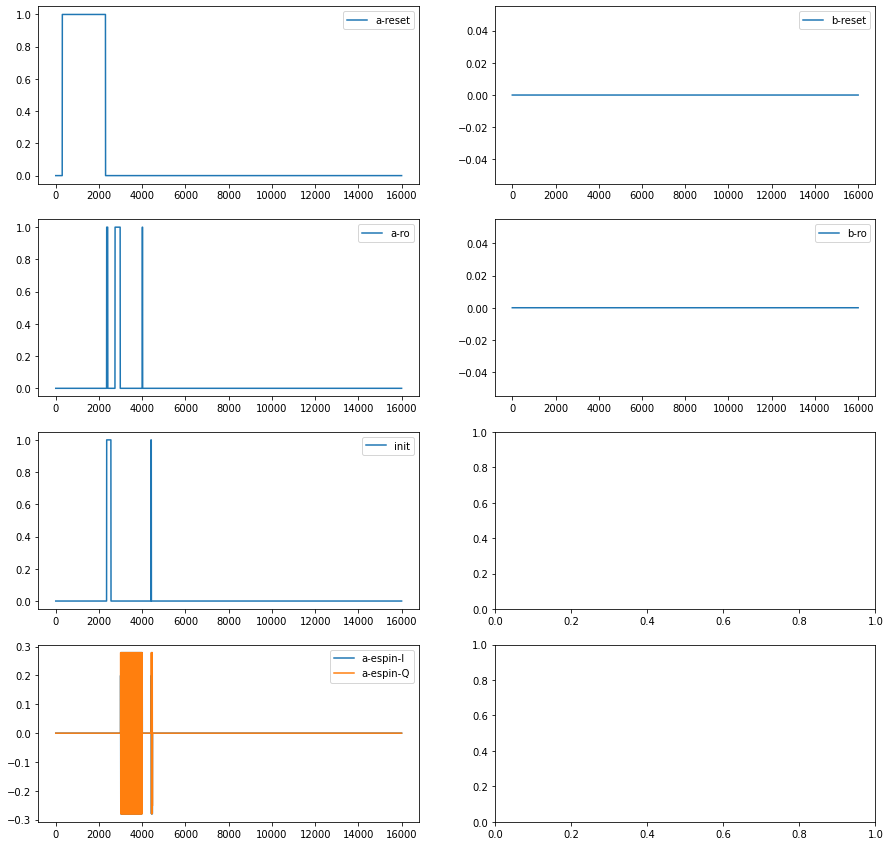

In [49]:
from qm.QuantumMachinesManager import QuantumMachinesManager
from qm.qua import *
from qm import SimulationConfig
from Configuration import config

import matplotlib.pyplot as plt

meas_len=52
short_meas_len=16

th=0

N_max=50
M_max=50

Qmm = QuantumMachinesManager()
Qmm.close_all_quantum_machines()
qm = Qmm.open_qm(config)
elements = ['a-reset','b-reset','b-ro','a-ro','a-init','a-espin','b-espin']

def A_CRINIT():     
    align('a-reset','a-ro','a-init')
    play("zeroPulse", "a-init",duration=50)        
    measure('readoutPulse','a-ro',None,time_tagging.analog(resultA, meas_len,targetLen= A_clicks))
    with if_(A_clicks<th):
        assign(a_state,1)
    with else_():
        assign(a_state,3)
        
def MBI():
    play('zeroPulse','a-ro',duration=60)
    align('a-ro','a-espin')
    play('CNOT','a-espin')
    align('a-ro','a-espin')
    measure('short_readoutPulse','a-ro',None,time_tagging.analog(resultA, short_meas_len,targetLen= A_clicks))
    with if_(A_clicks>=0):
        assign(alice_at_entangle,1)
        with while_(bob_at_entangle==0):
            wait(50,'a-ro')
        assign(a_state,4)
    with else_():
        with if_(N<N_max):
            assign(a_state,3)
        with else_():
            assign(a_state,2)

def a_entangle():
    play('zeroPulse','a-init',duration=5)
    align('a-init','a-espin')
    play('PI2','a-espin')
    align('a-espin','a-ro')
    play('zeroPulse','a-ro',duration=5)
    align('a-espin','a-ro')
    measure('short_readoutPulse','a-ro',None,time_tagging.analog(resultA, meas_len,targetLen= A_clicks))
    with if_(A_clicks==1):
        assign(alice_at_prep,1)
        with while_(bob_at_prep==0):
            wait(50,'a-ro')
        assign(a_state,5)
    with else_():
        with if_(Ma<M_max):
            assign(a_state,4)
        with else_():
            assign(Ma,0)
            assign(a_state,2)

def prep():
    play('constPulse','nspin')
    align('nspin','a-espin')
    play('PI','a-espin')
    align('nspin','a-espin')
    play('constPulse','nspin')
    assign(a_state,6)
    
def B_CRINIT():
    align('b-reset','b-ro','b-init')
    play("zeroPulse", "b-init",duration=50)        
    measure('readoutPulse','b-ro',None,time_tagging.analog(resultB, meas_len,targetLen= B_clicks))
    with if_(B_clicks<th):
        assign(b_state,1)
    with else_():
        assign(bob_at_entangle,1)
        with while_(alice_at_entangle==0):
            wait(50,'b-ro')
        assign(b_state,3)

def b_entangle():
    play('zeroPulse','b-init',duration=5)
    align('b-init','b-espin')
    play('PI2','b-espin')
    align('b-espin','b-ro')
    play('zeroPulse','b-ro',duration=5)
    align('b-espin','b-ro')
    measure('short_readoutPulse','b-ro',None,time_tagging.analog(resultB, meas_len,targetLen= B_clicks))
    with if_(B_clicks==1):
        assign(bob_at_prep,1)
        with while_(alice_at_prep==0):
            wait(50,'b-ro')
        assign(b_state,4)
    with else_():
        with if_(Mb<M_max):
            assign(a_state,3)
        with else_():
            assign(Mb,0)
            assign(a_state,2)

        
with program() as prog:
    a_state = declare(int,value=1)
    b_state = declare(int,value=1)
    A_clicks = declare(int,value=-1)
    B_clicks = declare(int,value=-1)
    cr_init = declare(int,value=1)
    N=declare(int,value=0)
    Ma=declare(int,value=0)
    Mb=declare(int,value=0)
    resultA = declare(int, size=100)
    resultB = declare(int, size=100)
    bob_at_entangle = declare(int,value=0)
    alice_at_entangle = declare(int,value=0)
    bob_at_prep = declare(int,value=0)
    alice_at_prep = declare(int,value=0)

    
    with while_(a_state<6 & b_state<4):
        
        ####ALICE state machine####
        with if_(a_state==1):
            play("zeroPulse", "a-reset",duration=500)
            assign(a_state,a_state+1)
        with if_(a_state==2):
            A_CRINIT()      
        with if_(a_state==3):
            MBI()
        with if_(a_state==4):
            a_entangle()
        with if_(a_state==5):
            prep()



        ####Bob state machine####
        with if_(b_state==1):
            play("zeroPulse", "a-reset",duration=500)
            assign(b_state,b_state+1)
        with if_(b_state==2):
            B_CRINIT()
        with if_(b_state==3):
            b_entangle()
        

    QMm = QuantumMachinesManager()
QMm.close_all_quantum_machines()

QM1 = QMm.open_qm(config)
job = QM1.simulate(prog, SimulationConfig(int(4000)),flags=['auto-element-thread'])  # in clock cycles, 4 ns

samples = job.get_simulated_samples()
# samples.con1.plot()
fig, axs = plt.subplots(4, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
axs[0,0].plot(samples.con1.digital['1'],label='a-reset')
axs[0,0].legend()
axs[1,0].plot(samples.con1.digital['2'],label='a-ro')
axs[1,0].legend()
axs[2,0].plot(samples.con1.digital['3'],label='init')
axs[2,0].legend()
axs[3,0].plot(samples.con1.analog['2'],label='a-espin-I')
axs[3,0].plot(samples.con1.analog['3'],label='a-espin-Q')
axs[3,0].legend()
axs[0,1].plot(samples.con1.digital['4'],label='b-reset')
axs[0,1].legend()
axs[1,1].plot(samples.con1.digital['5'],label='b-ro')
axs[1,1].legend()